#  Predicting the Sale Price of Bulldozers using Machine Learning 

## 1. Problem Definition

For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

## 2. Data

Looking at the [dataset from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data), you can you it's a time series problem. This means there's a time attribute to dataset.

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

## 3. Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).



In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-05-24 13:55:47.459338


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Import the training and validation set
df = pd.read_csv("data/Bulldozer/TrainAndValid.csv", low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [5]:
# Parse datetime to Python object
df = pd.read_csv("data/Bulldozer/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])

In [6]:
df.saledate.dtype

dtype('<M8[ns]')

In [7]:
#Sort DataFrame by saledate
#As we're working on a time series problem and trying to predict future examples given past examples, it makes sense to sort our data by date.

df.sort_values(by = ["saledate"], inplace=True, ascending=True)

In [8]:
df.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [9]:
df.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [10]:
# Make a copy for backup 
df_cp = df.copy()

## Visualize data


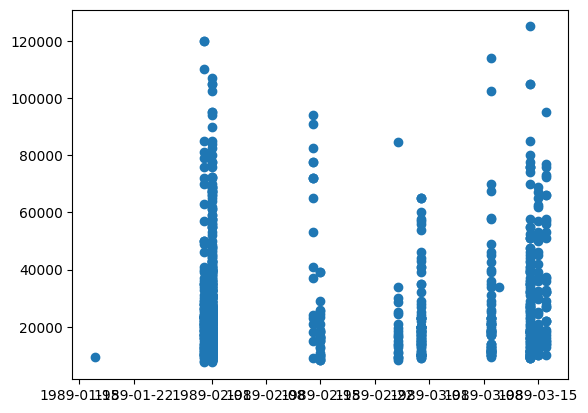

In [11]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);
 

# Feature Engineering

In [12]:
# Add datetime parameters for saledate
df["saleYear"] = df.saledate.dt.year
df["saleMonth"] = df.saledate.dt.month
df["saleDay"] = df.saledate.dt.day
df["saleDayofweek"] = df.saledate.dt.dayofweek
df["saleDayofyear"] = df.saledate.dt.dayofyear

# Drop original saledate
df.drop("saledate", axis=1, inplace=True)


In [13]:
df.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [14]:
# Check the different values of different columns
df.state.value_counts() , df.Hydraulics.value_counts()

(state
 Florida           67320
 Texas             53110
 California        29761
 Washington        16222
 Georgia           14633
 Maryland          13322
 Mississippi       13240
 Ohio              12369
 Illinois          11540
 Colorado          11529
 New Jersey        11156
 North Carolina    10636
 Tennessee         10298
 Alabama           10292
 Pennsylvania      10234
 South Carolina     9951
 Arizona            9364
 New York           8639
 Connecticut        8276
 Minnesota          7885
 Missouri           7178
 Nevada             6932
 Louisiana          6627
 Kentucky           5351
 Maine              5096
 Indiana            4124
 Arkansas           3933
 New Mexico         3631
 Utah               3046
 Unspecified        2801
 Wisconsin          2745
 New Hampshire      2738
 Virginia           2353
 Idaho              2025
 Oregon             1911
 Michigan           1831
 Wyoming            1672
 Montana            1336
 Iowa               1336
 Oklahoma         

In [15]:
# Check the different values of different columns
df.ProductSize.value_counts(),df.Enclosure.value_counts()

(ProductSize
 Medium            64342
 Large / Medium    51297
 Small             27057
 Mini              25721
 Large             21396
 Compact            6280
 Name: count, dtype: int64,
 Enclosure
 OROPS                  177971
 EROPS                  141769
 EROPS w AC              92601
 EROPS AC                   18
 NO ROPS                     3
 None or Unspecified         2
 Name: count, dtype: int64)

## 5. Modelling

We've explored our dataset a little as well as enriched it with some datetime attributes, now let's try to model.

Why model so early?

We know the evaluation metric we're heading towards. We could spend more time doing exploratory data analysis (EDA), finding more out about the data ourselves but what we'll do instead is use a machine learning model to help us do EDA.

Remember, one of the biggest goals of starting any new machine learning project is reducing the time between experiments.

Following the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), we find a [`RandomForestRegressor()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn-ensemble-randomforestregressor) might be a good candidate.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [18]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


In [16]:
# This won't work since we've got missing numbers and categories
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1)
model.fit(df.drop("SalePrice", axis=1), df.SalePrice)

ValueError: could not convert string to float: 'Low'

## Converting Strings into categories 

In [19]:
# check string containing columns

for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
    # if isinstance(content.dtype, pd.StringDtype):
        print(label) 

fiModelDesc
fiBaseModel
fiProductClassDesc
state
ProductGroup
ProductGroupDesc


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [21]:
# Try this way
# Get a list of object columns
object_columns = df.select_dtypes(include=['object']).columns
object_columns

Index(['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [22]:
# Convert all object columns to categorical
df[object_columns] = df[object_columns].astype('category')

# Now all object columns are converted to categorical data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [23]:
# Just checking some rows to ensure all is correct
df_cp.state[:15], df.state[:15]

(205615      Texas
 274835    Florida
 141296    Florida
 212552    Florida
 62755     Florida
 54653     Florida
 81383     Florida
 204924    Florida
 135376    Florida
 113390    Florida
 113394    Florida
 116419    Florida
 32138     Florida
 127610    Florida
 76171     Florida
 Name: state, dtype: object,
 205615      Texas
 274835    Florida
 141296    Florida
 212552    Florida
 62755     Florida
 54653     Florida
 81383     Florida
 204924    Florida
 135376    Florida
 113390    Florida
 113394    Florida
 116419    Florida
 32138     Florida
 127610    Florida
 76171     Florida
 Name: state, dtype: category
 Categories (53, object): ['Alabama', 'Alaska', 'Arizona', 'Arkansas', ..., 'Washington DC', 'West Virginia', 'Wisconsin', 'Wyoming'])

In [24]:
df.state.cat.categories, df.state.cat.codes

(Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
        'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
        'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
        'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
        'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
        'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
        'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
        'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
        'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
        'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
        'Wyoming'],
       dtype='object'),
 205615    43
 274835     8
 141296     8
 212552     8
 62755      8
           ..
 410879     4
 412476     4
 411927     4
 407124     4
 409203     4
 Length: 412698, dtype: int8)

In [25]:
# Check if there is any numeric value
for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [26]:
# Fill nan if there is any null numeric value
for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # add binary column of missing
            df[label+"_is_missing"] = pd.isnull(content)
            # Filling values
            df[label] = content.fillna(content.median())

In [27]:
# Check if there is any numeric value
for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)
            

In [28]:
df.auctioneerID_is_missing.value_counts()

auctioneerID_is_missing
False    392562
True      20136
Name: count, dtype: int64

In [29]:
df.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

In [30]:
# filling, if there is any missing values
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):  # Categorical
        if pd.isnull(content).sum():
            # print(label)
             # add binary column of missing labels
            df[label+"_is_missing"] = pd.isnull(content)
        # filling 
        df[label] = pd.Categorical(content).codes + 1
            # print(pd.Categorical(content).codes+1)
            

In [31]:
# print(df.isna().sum()
for label, content in df.items():
    if pd.isnull(content).sum():
        print(label)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 97 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   SalesID                              412698 non-null  int64  
 1   SalePrice                            412698 non-null  float64
 2   MachineID                            412698 non-null  int64  
 3   ModelID                              412698 non-null  int64  
 4   datasource                           412698 non-null  int64  
 5   auctioneerID                         412698 non-null  float64
 6   YearMade                             412698 non-null  int64  
 7   MachineHoursCurrentMeter             412698 non-null  float64
 8   UsageBand                            412698 non-null  int8   
 9   fiModelDesc                          412698 non-null  int16  
 10  fiBaseModel                          412698 non-null  int16  
 11  fiSecondaryDe

In [33]:
df[:8]

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
274835,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
141296,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
212552,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
62755,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True
54653,1301884,23500.0,1182999,4123,132,99.0,1976,0.0,0,2298,...,True,True,True,True,True,False,False,False,True,True
81383,1379228,31000.0,1082797,7620,132,99.0,1986,0.0,0,3126,...,True,True,True,True,True,True,True,True,False,False
204924,1645390,11750.0,1527216,8202,132,99.0,1970,0.0,0,979,...,True,True,True,True,True,True,True,True,False,False


## Lets save the data format 


In [34]:
# Export to csv
df.to_csv("data/Bulldozer/preprocessed_train_valid.csv", index=False)

## Lets re train the model now,

In [35]:
%%time
# Lets train a model now, no missing values and all are numerics
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_jobs=-1, random_state=1)
model_rf.fit(df.drop("SalePrice", axis=1), df.SalePrice)

CPU times: total: 36min 58s
Wall time: 3min 39s


RandomForestRegressor(n_jobs=-1, random_state=1)

In [36]:
%%time
model_rf.score(df.drop("SalePrice", axis=1), df.SalePrice)

CPU times: total: 21.9 s
Wall time: 20.9 s


0.9875876197121375

In [37]:
import pickle as pk

In [38]:
pk.dump(model_rf, open("bulldozer_rf_model.pkl","wb"))

## Re Initiating from here

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [40]:
df = pd.read_csv("data/Bulldozer/preprocessed_train_valid.csv",low_memory=False )

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 97 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   SalesID                              412698 non-null  int64  
 1   SalePrice                            412698 non-null  float64
 2   MachineID                            412698 non-null  int64  
 3   ModelID                              412698 non-null  int64  
 4   datasource                           412698 non-null  int64  
 5   auctioneerID                         412698 non-null  float64
 6   YearMade                             412698 non-null  int64  
 7   MachineHoursCurrentMeter             412698 non-null  float64
 8   UsageBand                            412698 non-null  int64  
 9   fiModelDesc                          412698 non-null  int64  
 10  fiBaseModel                          412698 non-null  int64  
 11  fiSecondaryDe

In [42]:
# Spliting data into train and valid
df_val = df[df.saleYear == 2012]
df_train = df[df.saleYear != 2012]

df_val.shape, df_train.shape

((11573, 97), (401125, 97))

In [43]:
# Split into X and y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

In [44]:
X_train.shape, y_train.shape , X_valid.shape, y_valid.shape

((401125, 96), (401125,), (11573, 96), (11573,))

## Building evalution metric (competition uses RMSLE)

In [45]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

def rmsle(y_test, y_preds):
    """Calculate Root mean squared log error."""
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Fuction to show metrics dict
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid )
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Valid R^2": model.score(X_valid, y_valid)}
    return scores

## Tuning model in a subset of training data (for faster speed currently)


In [46]:
%%time

from sklearn.ensemble import RandomForestRegressor

m_rf_1 = RandomForestRegressor(n_jobs=-1, random_state=1, max_samples=10000)
m_rf_1.fit( X_train, y_train)

CPU times: total: 1min 5s
Wall time: 7.01 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=1)

In [47]:
%%time
show_scores(m_rf_1)

CPU times: total: 29.2 s
Wall time: 3.58 s


{'Training MAE': 5557.179337463384,
 'Valid MAE': 7125.846232610386,
 'Training RMSLE': 0.2576330668012108,
 'Valid RMSLE': 0.29236372019269974,
 'Training R^2': 0.8609037868591972,
 'Valid R^2': 0.8349937929672557}

In [48]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 10, 2),
           "min_samples_leaf": np.arange(1, 10, 2),
           "max_features": [0.5, "sqrt", None], 
           "max_samples": [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1),
                              param_distributions=rf_grid,
                              n_iter=5,
                              cv=3,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: total: 4min 32s
Wall time: 37.8 s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1), n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 'sqrt', None],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([1, 3, 5, 7, 9]),
                                        'min_samples_split': array([2, 4, 6, 8]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [49]:
# Find the best parameters from the RandomizedSearch 
rs_model.best_params_

{'n_estimators': 70,
 'min_samples_split': 4,
 'min_samples_leaf': 7,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [50]:
show_scores(rs_model)

{'Training MAE': 6198.029659201763,
 'Valid MAE': 7535.863119122815,
 'Training RMSLE': 0.2803581599356569,
 'Valid RMSLE': 0.3045972188063584,
 'Training R^2': 0.8287372098772732,
 'Valid R^2': 0.8133556481240152}

In [51]:
%%time
# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=80,
                                    min_samples_leaf=5,
                                    min_samples_split=6,
                                    max_features=None,
                                    n_jobs=-1,
                                    max_samples=None,
                                   random_state =1)
# ideal_model = RandomForestRegressor(n_estimators=90,
#                                     min_samples_leaf=1,
#                                     min_samples_split=14,
#                                     max_features=0.5,
#                                     n_jobs=-1,
#                                     max_samples=None)
ideal_model.fit(X_train, y_train)

CPU times: total: 26min 25s
Wall time: 2min 48s


RandomForestRegressor(max_features=None, min_samples_leaf=5,
                      min_samples_split=6, n_estimators=80, n_jobs=-1,
                      random_state=1)

In [52]:
show_scores(ideal_model)

{'Training MAE': 2952.0250950244977,
 'Valid MAE': 6075.356238739329,
 'Training RMSLE': 0.1479896088320459,
 'Valid RMSLE': 0.2500019560393017,
 'Training R^2': 0.9554738640834772,
 'Valid R^2': 0.8730509004098401}

### Preprocessing the test data
 
 Whatever you do to the training data, you have to do to the test data.


In [53]:

# Let's create a function for doing so (by copying the preprocessing steps we used above).
def preprocess_data(df_t):
    # Add datetime parameters for saledate
    df_t["saleYear"] = df_t.saledate.dt.year
    df_t["saleMonth"] = df_t.saledate.dt.month
    df_t["saleDay"] = df_t.saledate.dt.day
    df_t["saleDayofweek"] = df_t.saledate.dt.dayofweek
    df_t["saleDayofyear"] = df_t.saledate.dt.dayofyear

    # Drop original saledate
    df_t.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df_t.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df_t[label+"_is_missing"] = pd.isnull(content)
                df_t[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df_t[label+"_is_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            df_t[label] = pd.Categorical(content).codes+1        
    
    return df_t

In [54]:
df_test = pd.read_csv("data/Bulldozer/Test.csv",
                      parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [55]:
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [56]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [57]:
# Match test dataset columns to training dataset
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [58]:
# Match column order from X_train to df_test (to predict on columns, they should be in the same order they were fit on)
df_test = df_test[X_train.columns]

In [59]:
# Make predictions on the test dataset using the best model
test_preds = ideal_model.predict(df_test)

In [60]:
test_preds[:5]

array([21106.51006775, 16841.26129869, 48620.26079823, 89297.53855417,
       60855.05537555])

In [61]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([4.69283715e-02, 1.20217870e-02, 3.16460036e-02, 1.73010761e-04,
       2.80050645e-03, 2.73206144e-01, 2.08117173e-03, 7.67289695e-04,
       1.94175474e-02, 8.21653248e-02, 5.26417862e-02, 4.07594113e-03,
       3.02522089e-03, 2.38213591e-01, 4.15885455e-02, 6.01368823e-03,
       1.44814868e-04, 1.27789678e-04, 1.74738360e-03, 8.90567720e-03,
       1.83914932e-04, 1.78216086e-05, 4.21730163e-04, 1.67613980e-04,
       1.36074100e-03, 8.84358617e-06, 4.38970554e-04, 5.12417579e-03,
       9.68854924e-05, 1.82689412e-03, 2.61353586e-03, 1.90216399e-03,
       1.90067648e-03, 3.71796263e-03, 3.29263178e-04, 1.49034568e-03,
       6.13900873e-04, 1.57045955e-02, 4.27785241e-06, 1.05609686e-06,
       1.31354083e-04, 8.47378321e-04, 9.52503568e-04, 5.37225130e-04,
       1.44887406e-04, 2.24987051e-04, 2.28122529e-04, 1.23103923e-03,
       8.56994669e-04, 1.33238973e-04, 2.49730465e-04, 7.78823475e-02,
       1.86514641e-03, 5.83439692e-03, 2.67938405e-03, 1.16775750e-02,
      

In [62]:
import seaborn as sns

# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

ModuleNotFoundError: No module named 'seaborn'

In [63]:
plot_features(X_train.columns, ideal_model.feature_importances_)

NameError: name 'plot_features' is not defined

In [64]:
sum(ideal_model.feature_importances_)

1.0

In [65]:
df_test.ProductSize.value_counts()

ProductSize
0    6409
4    2030
3    1695
5     997
6     724
2     444
1     158
Name: count, dtype: int64

In [68]:
from utils.py import ModelEvaluator
evaluator = ModelEvaluator(ideal_model, X_train, y_train, X_test, y_test, is_classifier=False)
evaluator.evaluate()

ModuleNotFoundError: No module named 'utils'